# Predicting transposon insertion bias from DNA sequence

In this notebook, I'll play around with models defined in tn_motif with the goal of identifying a DNA motif for the mariner transposon. 

In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
from tn_motif.utils import dataset, training, encode

In [3]:
from tn_motif.models import model_classes

In [497]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [426]:
alphabet_size = len(encode.ALPHABET)

## Setting up dataset

**Loading sequences and counts**

In [ ]:
ref_genome_path = "../transposon_binding_motif/data/PROKKA_03162021.gbk"

In [425]:
counts_path = "../transposon_binding_motif/data/mutant_trajectories_replicate_1.csv"

In [427]:
## REPLICATE 1
sequences, log_counts = dataset.process_inputs(path_counts_table=counts_path, 
                                               path_ref_genome=ref_genome_path,
                                               focal_TA_site=True,
                                               flank_length=25)

In [428]:
sequence_length = len(sequences[0])

**Create Dataset object**

In [493]:
tn_dataset = dataset.DNADataset(sequences=sequences, counts=log_counts.tolist())

## Comparing technical replicates

In [488]:
counts_path_2 = "../transposon_binding_motif/data/mutant_trajectories_replicate_2.csv"

In [489]:
## REPLICATE 2
sequences_2, log_counts_2 = dataset.process_inputs(path_counts_table=counts_path_2, 
                                               path_ref_genome=ref_genome_path,
                                               focal_TA_site=True,
                                               flank_length=25)

[Text(0.5, 32.99999999999995, 'log10(counts), replicate 1'),
 Text(27.0, 0.5, 'log10(counts), replicate 2')]

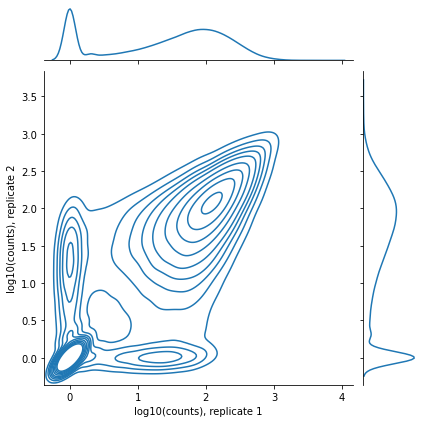

In [496]:
ax = sns.jointplot(x=log_counts, y=log_counts_2, kind='kde')
ax.ax_joint.set(xlabel="log10(counts), replicate 1", ylabel="log10(counts), replicate 2")

In [501]:
stats.pearsonr(log_counts_2, log_counts)[0]**2

0.4616915440062213

## Linear regression baseline

In [430]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [431]:
encoded_sequences_np = [encode.one_hot_encode_sequence(seq).reshape(1,-1)[0] for seq in sequences]

In [432]:
regressor = Ridge()
regressor.fit(encoded_sequences_np, log_counts)
print(f"Fraction of variance in log(counts) explained by sequence with linear model: \
{regressor.score(encoded_sequences_np, log_counts):.4f}")

Fraction of variance in log(counts) explained by sequence with linear model: 0.2642


**Observations**

The linear regression model captures around 26.5% of the variation in the counts, given sequence. 

In this experiment, the technical replicates have a pearson correlation of 0.72. So the maximum explainable variation is ~50%. Let's see if the neural network models can improve upon that. Before doing that I'll visualize the linear regression model weights.coefficients

In [433]:
coefficients = regressor.coef_
coefficients_reshaped = np.reshape(coefficients, (-1, 4))

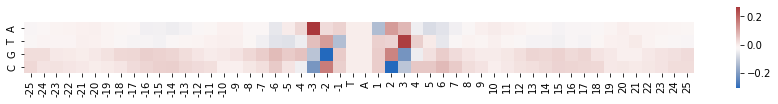

In [434]:
fig,ax = plt.subplots(figsize=(15, 1.5))
sns.heatmap(coefficients_reshaped.T, cmap=sns.color_palette("vlag", as_cmap=True), square=True, ax=ax)
ax.set_xticklabels([*np.linspace(-25,-1, 25).astype("int"),*["T", "A"], *np.linspace(1,25, 25).astype("int")], rotation=90)
ax.set_yticklabels(["A","T","G", "C"])
ax.set_title("Ridge regression coefficients")
plt.show()

**Observations pt. 2**

Immediately adjacent to the transposon site, an increase in GC content leads to reduction in number of counts (note the negative coefficients for G and C from -3 to +3. However, further away from the site, higher GC content appears to correlate with increased binding. 

Another important feature is that model weights are symmetric around the TA site, which is expected because the TA site is palindromic. The transposon should not have any bias towards binding on the forward vs reverse strand (that distinction is arbitrary here).

With the deep learning models, I want to investigate if we can better predict the motif sequence, and identify secondary motifs further away from the focal transposon insertion site

## Setting up deep learning models

**Defining the model parameters**

In [439]:
model_params_conv = {"alphabet_size": 4, "conv_channels":25, 
                "conv_kernel_size": 5, "pool_kernel_size":3,
                "dropout_rate":0.1,"dense_layer_size":16, "sequence_length": tn_dataset.sequence_length}

In [448]:
model_params_mlp = {"alphabet_size": 4, "sequence_length": tn_dataset.sequence_length, "dense_layer_sizes":[128,64]}

**Instantiate model training objects**

In [450]:
mlp_trainer = training.ModelTraining(model_class = model_classes.DNABindingMLP,
                                       model_params=model_params_mlp,
                                       dataset=tn_dataset,
                                       criterion="mse",
                                       optimizer="adam",
                                       num_epochs=20,
                                       batch_size=512, 
                                       learning_rate=0.01, verbose=False)

In [451]:
cnn_trainer = training.ModelTraining(model_class = model_classes.DNABindingCNN,
                                       model_params=model_params_conv,
                                       dataset=tn_dataset,
                                       criterion="mse",
                                       optimizer="adam",
                                       num_epochs=12,
                                       batch_size=512, 
                                       learning_rate=0.01, verbose=False)

## Perform k-fold cross validation

### MLP model

In [452]:
mlp_training_losses, mlp_validation_metrics = mlp_trainer.cross_validation()


--- Fold 1/5 ---
Epoch [1/20], Training Loss: 0.8114
    Validation Loss: 0.5867, Pearson R: 0.5059, Spearman R: 0.5017
Epoch [2/20], Training Loss: 0.5697
    Validation Loss: 0.5668, Pearson R: 0.5262, Spearman R: 0.5214
Epoch [3/20], Training Loss: 0.5440
    Validation Loss: 0.5275, Pearson R: 0.5674, Spearman R: 0.5563
Epoch [4/20], Training Loss: 0.5149
    Validation Loss: 0.5097, Pearson R: 0.5867, Spearman R: 0.5748
Epoch [5/20], Training Loss: 0.4916
    Validation Loss: 0.4736, Pearson R: 0.6209, Spearman R: 0.6131
Epoch [6/20], Training Loss: 0.4694
    Validation Loss: 0.4675, Pearson R: 0.6280, Spearman R: 0.6187
Epoch [7/20], Training Loss: 0.4600
    Validation Loss: 0.4616, Pearson R: 0.6349, Spearman R: 0.6278
Epoch [8/20], Training Loss: 0.4541
    Validation Loss: 0.4564, Pearson R: 0.6393, Spearman R: 0.6322
Epoch [9/20], Training Loss: 0.4488
    Validation Loss: 0.4540, Pearson R: 0.6434, Spearman R: 0.6370
Epoch [10/20], Training Loss: 0.4416
    Validation Los

### CNN model

In [453]:
cnn_training_losses, cnn_validation_metrics = cnn_trainer.cross_validation()


--- Fold 1/5 ---
Epoch [1/12], Training Loss: 0.6849
    Validation Loss: 0.4320, Pearson R: 0.6665, Spearman R: 0.6687
Epoch [2/12], Training Loss: 0.4590
    Validation Loss: 0.4142, Pearson R: 0.6842, Spearman R: 0.6907
Epoch [3/12], Training Loss: 0.4435
    Validation Loss: 0.4057, Pearson R: 0.6916, Spearman R: 0.6987
Epoch [4/12], Training Loss: 0.4373
    Validation Loss: 0.4138, Pearson R: 0.6890, Spearman R: 0.6994
Epoch [5/12], Training Loss: 0.4361
    Validation Loss: 0.4037, Pearson R: 0.6917, Spearman R: 0.7006
Epoch [6/12], Training Loss: 0.4302
    Validation Loss: 0.4102, Pearson R: 0.6891, Spearman R: 0.7001
Epoch [7/12], Training Loss: 0.4298
    Validation Loss: 0.4196, Pearson R: 0.6917, Spearman R: 0.7010
Epoch [8/12], Training Loss: 0.4312
    Validation Loss: 0.4032, Pearson R: 0.6955, Spearman R: 0.7034
Epoch [9/12], Training Loss: 0.4279
    Validation Loss: 0.4017, Pearson R: 0.6941, Spearman R: 0.7027
Epoch [10/12], Training Loss: 0.4250
    Validation Los

### Get final model performance scores

In [477]:
cnn_validation_last_epoch = pd.DataFrame({key: val[-1] for key, val in cnn_validation_metrics.items()}).T

In [478]:
mlp_validation_last_epoch = pd.DataFrame({key: val[-1] for key, val in mlp_validation_metrics.items()}).T

cnn_validation_last_epoch.mean()

In [480]:
mlp_validation_last_epoch.mean()

pearson_r       0.674705
spearman_rho    0.675681
loss            0.426547
dtype: float64

In [485]:
print(f"Fraction of variation in log(counts) predicted by the convolutional neural network:\n{cnn_validation_last_epoch.mean()['pearson_r']**2:4f}")

Fraction of variation in log(counts) predicted by the convolutional neural network:
0.489846


In [486]:
print(f"Fraction of variation in log(counts) predicted by the MLP neural network:\n{mlp_validation_last_epoch.mean()['pearson_r']**2:4f}")

Fraction of variation in log(counts) predicted by the MLP neural network:
0.455227


**Observation**

Both the CNN and the MLP models do much better than base linear model ($R^{2} \approx 0.26$), and capture nearly all the experimental variation observed across replicates. 

## Next steps:

In a separate notebook, I'll explore ways to infer the sequence of the transposon binding motif from the trained convolutional neural network